In [17]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# MPS Simulation with Two-site TDVP

In [41]:
from typing import Dict, List

from numpy import eye, zeros, asarray, kron, ndarray, mean, abs
from matplotlib.pyplot import subplots, show, title
from tqdm import tqdm

from pytreenet.ttno import TreeTensorNetworkOperator
from pytreenet.special_ttn.mps import MatrixProductState
from pytreenet.operators import Hamiltonian, TensorProduct
from pytreenet.operators.common_operators import pauli_matrices
from pytreenet.operators.sim_operators import single_site_operator_all_sites
from pytreenet.time_evolution import (ExactTimeEvolution,
                                      SecondOrderTwoSiteTDVP,
                                      TTNTimeEvolutionConfig,
                                      TimeEvolution)
from pytreenet.util.tensor_splitting import SVDParameters

In [19]:
final_time = 1.0

In [20]:
num_sites = 7
local_dim = 2
mps = MatrixProductState.constant_product_state(0,local_dim,
                                                num_sites,
                                                root_site=3)

In [21]:
def generate_ham_ising_model(factor: float,
                             ext_magn: float,
                             num_sites: int
                             ) -> Hamiltonian:
    """
    Generate the Ising model Hamiltonian for an MPS with a given number of sites.
    """
    mJ = -1*factor
    mg = -1*ext_magn
    interaction_terms = [TensorProduct({"site"+str(site): "mJX","site"+str(site+1): "X"})
                        for site in range(num_sites-1)]
    single_site_terms = [TensorProduct({"site"+str(i): "mgZ"}) for i in range(num_sites)]
    terms = interaction_terms
    terms.extend(single_site_terms)
    paulis = pauli_matrices()
    conversion_dict = {"mJX": mJ * paulis[0],
                    "X": paulis[0],
                    "mgZ": mg * paulis[2],
                    "I2": eye(2)}
    hamiltonian = Hamiltonian(terms, conversion_dict)
    return hamiltonian

def generate_ising_model_mpo(factor: float,
                             ext_magn: float,
                             mps: MatrixProductState) -> TreeTensorNetworkOperator:
    """
    Generate the MPO of an Ising model.
    """
    ham = generate_ham_ising_model(factor,ext_magn,mps.num_nodes())
    return TreeTensorNetworkOperator.from_hamiltonian(ham,
                                                      mps)

In [22]:
factor = 1.0
ext_magn = 3.0
ising_ttno = generate_ising_model_mpo(factor,ext_magn,mps)

In [23]:
operators = single_site_operator_all_sites(pauli_matrices()[2],mps)
print(operators)

{'site3': {'site3': array([[ 1.+0.j,  0.+0.j],
       [ 0.+0.j, -1.+0.j]])}, 'site2': {'site2': array([[ 1.+0.j,  0.+0.j],
       [ 0.+0.j, -1.+0.j]])}, 'site1': {'site1': array([[ 1.+0.j,  0.+0.j],
       [ 0.+0.j, -1.+0.j]])}, 'site0': {'site0': array([[ 1.+0.j,  0.+0.j],
       [ 0.+0.j, -1.+0.j]])}, 'site4': {'site4': array([[ 1.+0.j,  0.+0.j],
       [ 0.+0.j, -1.+0.j]])}, 'site5': {'site5': array([[ 1.+0.j,  0.+0.j],
       [ 0.+0.j, -1.+0.j]])}, 'site6': {'site6': array([[ 1.+0.j,  0.+0.j],
       [ 0.+0.j, -1.+0.j]])}}


### The Exact Simulation

In [24]:
def gernerate_exact_hamiltonian(factor: float,
                                ext_magn: float,
                                num_sites: int) -> ndarray:
    """
    Generate the exact Hamiltonian for an Ising model.
    """
    mJ = -1*factor
    mg = -1*ext_magn
    local_dim = 2
    ham = zeros((2**num_sites,2**num_sites), dtype=complex)
    # Single site terms
    for i in range(num_sites):
        term = asarray([1.0], dtype=complex)
        for j in range(num_sites):
            if j == i:
                term = kron(term,mg*pauli_matrices()[2])
            else:
                term = kron(term,eye(2))
        ham += term
    # Interaction terms
    for i in range(num_sites-1):
        term = asarray([1.0], dtype=complex)
        for j in range(num_sites):
            if j == i:
                term = kron(term,mJ*pauli_matrices()[0])
            elif j == i+1:
                term = kron(term,pauli_matrices()[0])
            else:
                term = kron(term,eye(2))
        ham += term
    return ham

def generate_exact_initial_state(num_sites: int,
                                 local_dim: int) -> ndarray:
    """
    Generate the exact all zero initial state for an Ising model.
    """
    state = zeros(local_dim**num_sites, dtype=complex)
    state[0] = 1.0
    return state

def generate_exact_operators(num_sites: int) -> Dict[str,ndarray]:
    """
    Generate the exact single site operators for all sites.
    """
    operators = {}
    for i in range(num_sites):
        operator = asarray([1.0], dtype=complex)
        for j in range(num_sites):
            if j == i:
                operator = kron(operator,pauli_matrices()[2])
            else:
                operator = kron(operator,eye(2))
        operators["site"+str(i)] = operator
    return operators

In [25]:
time_step_size = 0.01
initial_state_exact = generate_exact_initial_state(num_sites,local_dim)
ham_exact = gernerate_exact_hamiltonian(factor,ext_magn,num_sites)
operators_exact = generate_exact_operators(num_sites)
exact_evo = ExactTimeEvolution(initial_state_exact, ham_exact,
                               time_step_size, final_time,
                               operators_exact)

In [26]:
exact_evo.run()

100%|██████████| 101/101 [00:00<00:00, 1786.56it/s]


### A first comparison

In [27]:
svd = SVDParameters(max_bond_dim=8,
                    rel_tol=0.0,
                    total_tol=0.0)
config = TTNTimeEvolutionConfig(record_bond_dim=True)
test_tdvp = SecondOrderTwoSiteTDVP(mps,ising_ttno,
                                   time_step_size,final_time,
                                   operators,
                                   truncation_parameters=svd,
                                   config=config)

In [28]:
test_tdvp.run()

100%|██████████| 101/101 [00:02<00:00, 37.84it/s]


In [29]:
def compute_total_magn(evo: TimeEvolution) -> ndarray:
    """
    Compute the total magnetization of the system.
    """
    # The last line is the times
    local_magn = evo.operator_results(realise=True)[:-1]
    # Now we have the site index change with the first index and the time with the second
    magn = mean(local_magn,axis=0)
    return magn

In [30]:
times = exact_evo.times()
magn_exact = compute_total_magn(exact_evo)
magn_tdvp = compute_total_magn(test_tdvp)
print(times.shape)
print(magn_exact.shape)
print(magn_tdvp.shape)

(101,)
(101,)
(101,)


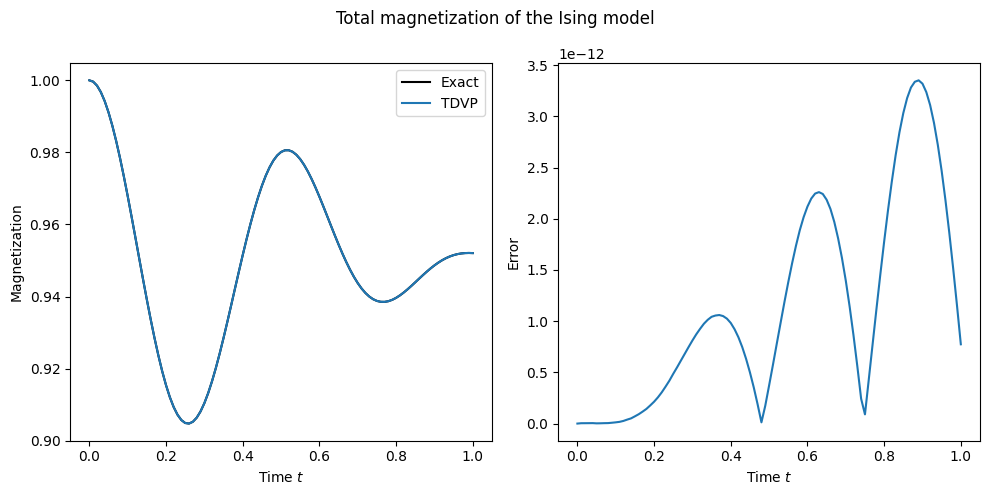

In [31]:
figure, axs = subplots(1,2, figsize=(10,5))

axs[0].plot(times,magn_exact,label="Exact",color="black")
axs[0].plot(times,magn_tdvp,label="TDVP")
axs[0].set_xlabel("Time $t$")
axs[0].set_ylabel("Magnetization")
axs[0].legend()

axs[1].plot(times,abs(magn_exact-magn_tdvp))
axs[1].set_xlabel("Time $t$")
axs[1].set_ylabel("Error")

figure.suptitle("Total magnetization of the Ising model")
figure.tight_layout()
show()

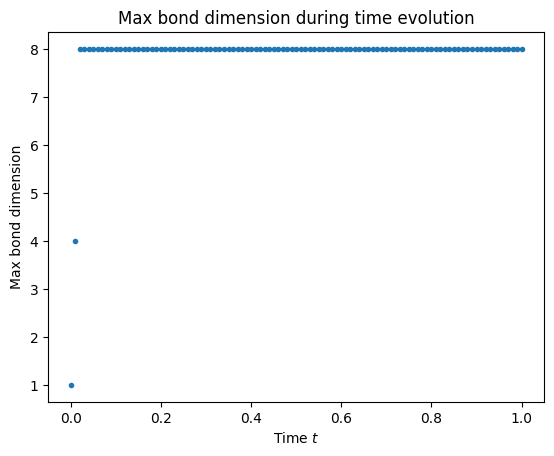

In [32]:
max_bond_dims = test_tdvp.max_bond_dim()
fig, ax = subplots(1,1)
ax.plot(times,max_bond_dims,".")
ax.set_xlabel("Time $t$")
ax.set_ylabel("Max bond dimension")
ax.set_title("Max bond dimension during time evolution")
show()

In [38]:
def generate_time_step_size(max_power: int,
                            final_time: float = 1.0
                            ) -> List[float]:
    """
    Generate a list of time step sizes for the time evolution.
    """
    num_time_steps = []
    for i in range(max_power):
        num_time_steps.extend(range(10**i,10**(i+1),10**i))
    time_step_sizes = [final_time/num_steps for num_steps in num_time_steps]
    return time_step_sizes

time_step_sizes = generate_time_step_size(4, final_time)
print(time_step_sizes)

[1.0, 0.5, 0.3333333333333333, 0.25, 0.2, 0.16666666666666666, 0.14285714285714285, 0.125, 0.1111111111111111, 0.1, 0.05, 0.03333333333333333, 0.025, 0.02, 0.016666666666666666, 0.014285714285714285, 0.0125, 0.011111111111111112, 0.01, 0.005, 0.0033333333333333335, 0.0025, 0.002, 0.0016666666666666668, 0.0014285714285714286, 0.00125, 0.0011111111111111111, 0.001, 0.0005, 0.0003333333333333333, 0.00025, 0.0002, 0.00016666666666666666, 0.00014285714285714287, 0.000125, 0.00011111111111111112]


In [39]:
def generate_tdvp_for_time_step_size(time_step_size: float) -> SecondOrderTwoSiteTDVP:
    """
    Generate a TDVP for a given time step size.
    """
    return SecondOrderTwoSiteTDVP(mps,ising_ttno,
                                  time_step_size,final_time,
                                  operators,
                                  truncation_parameters=svd,
                                  config=config)

In [40]:
tdvps = [generate_tdvp_for_time_step_size(time_step_size) for time_step_size in time_step_sizes]
for tdvp in tqdm(tdvps):
    tdvp.run()

100%|██████████| 9001/9001 [03:08<00:00, 47.71it/s]


In [46]:
def get_final_magnetisation(evo: TimeEvolution) -> float:
    """
    Get the final magnetisation of a TDVP.
    """
    return compute_total_magn(evo)[-1]

In [48]:
final_magns = [get_final_magnetisation(tdvp) for tdvp in tdvps]
exact_magn = get_final_magnetisation(test_tdvp)
error_magns = [abs(magn-exact_magn) for magn in final_magns]

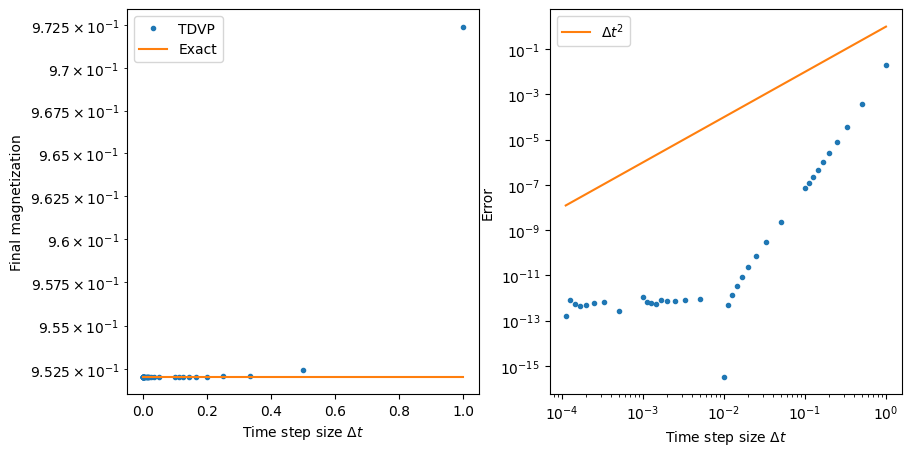

In [58]:
fig, axs = subplots(1,2, figsize=(10,5))

axs[0].semilogy(time_step_sizes,final_magns,".",label="TDVP")
axs[0].semilogy(time_step_sizes,[exact_magn]*len(time_step_sizes),label="Exact")
axs[0].set_xlabel("Time step size $\Delta t$")
axs[0].set_ylabel("Final magnetization")
axs[0].legend()

axs[1].loglog(time_step_sizes,error_magns,".")
axs[1].loglog(time_step_sizes,[t**2 for t in time_step_sizes],label="$\Delta t^2$")
axs[1].set_xlabel("Time step size $\Delta t$")
axs[1].set_ylabel("Error")
axs[1].legend()

show()